In [135]:
import sys
import inspect
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
tt = torch.tensor
import pyro
from pyro.distributions import Normal, Exponential, Binomial, Uniform, Beta
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.mcmc.nuts import HMC
from pyro.infer import EmpiricalMarginal

from models import RegressionBase
from utils import precis, sample_posterior
import arviz as az

# torch.multiprocessing.set_start_method("forkserver", force=True)
torch.multiprocessing.set_sharing_strategy("file_system")
plt.rcParams["figure.autolayout"] = True

seed=7
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [136]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Aug 09 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

pandas    : 2.2.2
arviz     : 0.17.1
pyro      : 1.9.1
matplotlib: 3.9.0
torch     : 2.3.0
numpy     : 1.26.4
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]

Watermark: 2.4.3



### Code 9.1
Simple simulation to reproduce the "Metropolis algorithm" (not the real one, the simplified one from the story about "King Markov" and his island kingdom).

In [137]:
num_weeks = 1e5
positions = np.zeros(int(num_weeks))
current = 10
for i in range(int(num_weeks)):
    positions[i] = current
    proposal = current + np.random.choice((-1, 1))
    if proposal < 1: proposal = 10
    if proposal > 10: proposal = 1
    
    prob_move = proposal/current # min(1, prob_move)
    current = proposal if np.random.rand() < prob_move else current


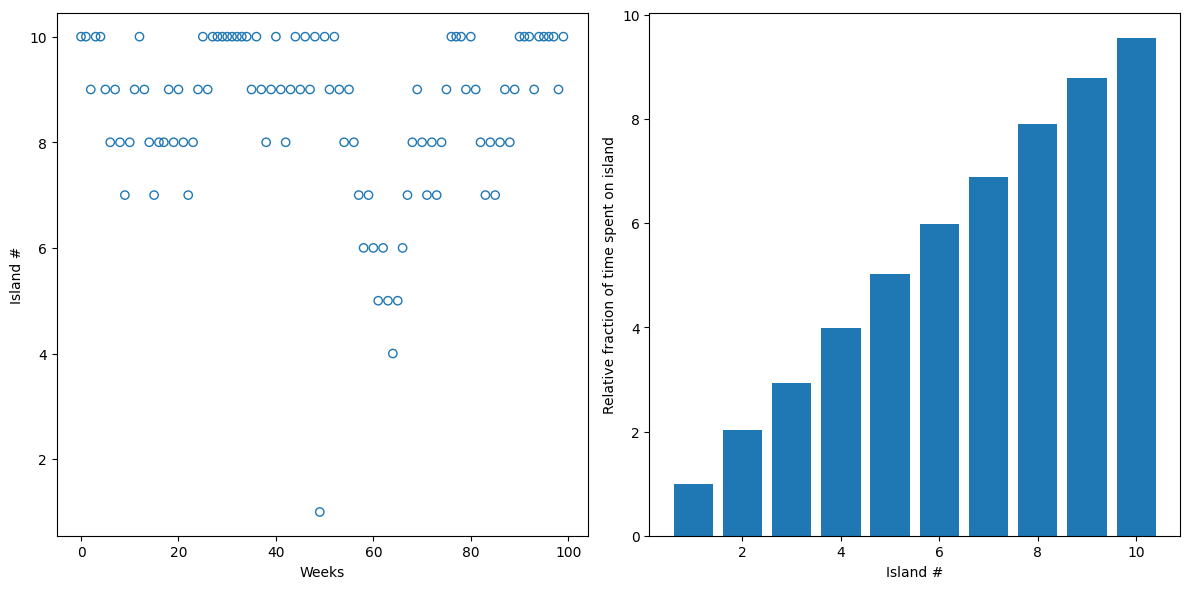

In [138]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
# Plot the markov chain samples
plt.sca(axes[0])
plt.scatter(np.arange(100), positions[:100], facecolor="none", edgecolor="C0")
plt.xlabel("Weeks")
plt.ylabel("Island #")
# Plot relative fraction of visitation frequency
plt.sca(axes[1])
val, count = np.unique(positions, return_counts=True)
plt.bar(val, height=count/count[0])
plt.xlabel("Island #")
plt.ylabel("Relative fraction of time spent on island")
plt.show()

## code 9.2-9.3

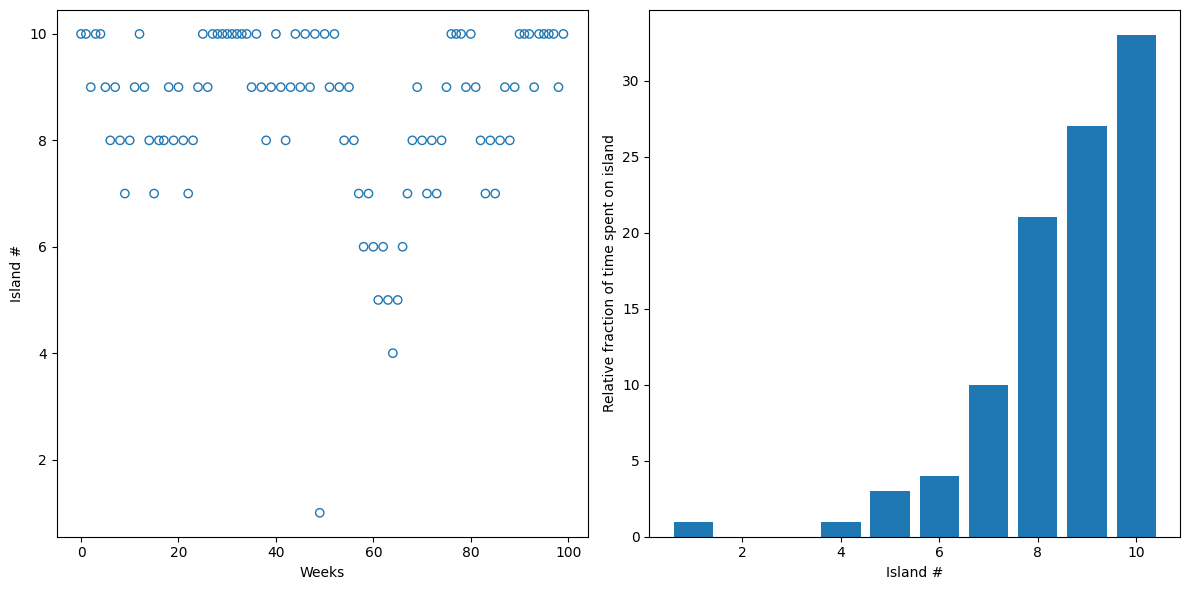

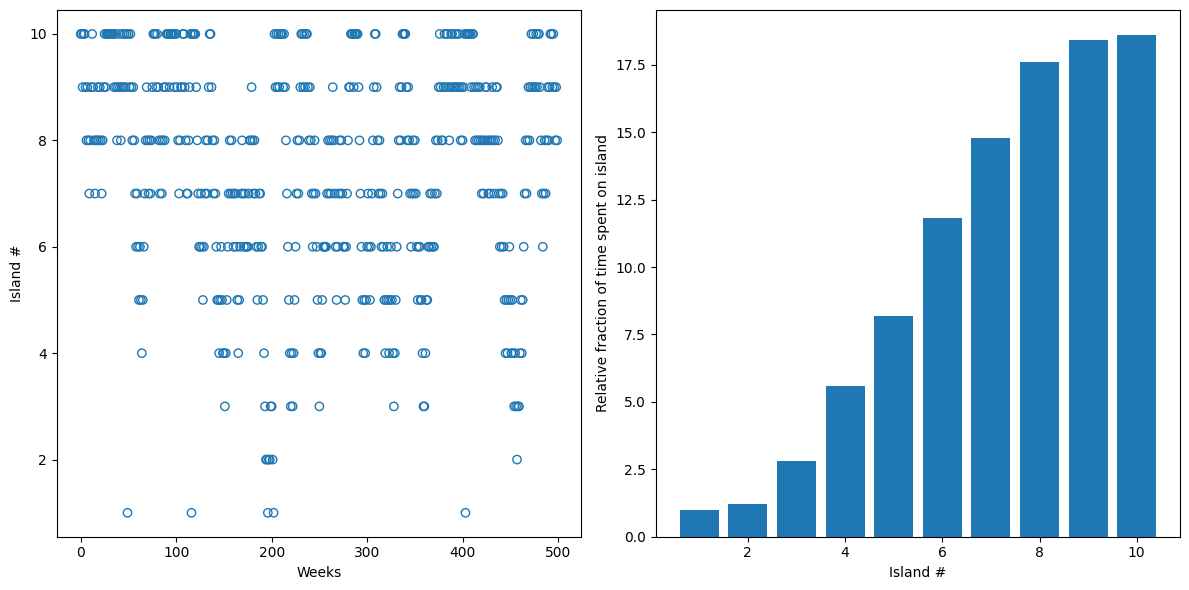

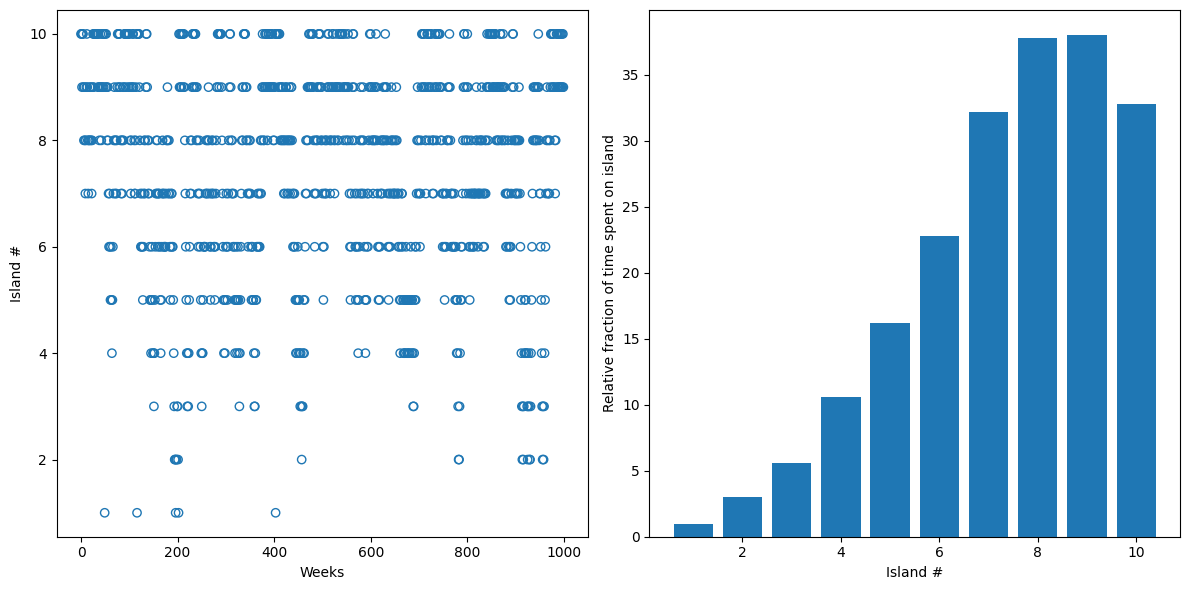

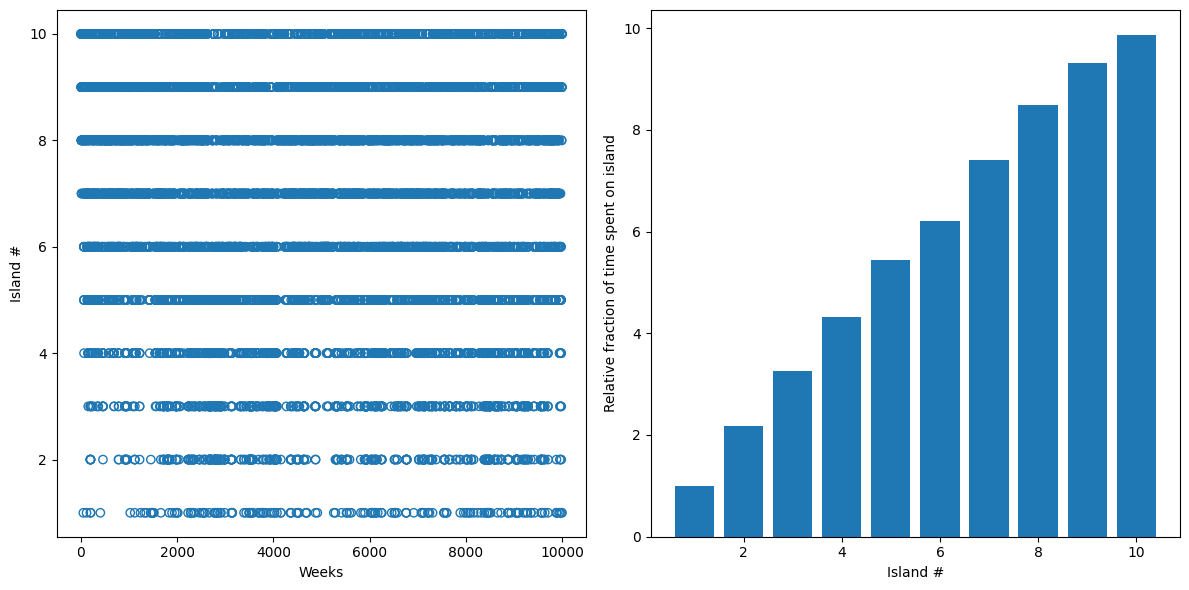

In [139]:
def p(n):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
    # Plot the markov chain samples
    plt.sca(axes[0])
    num_samples = n
    plt.scatter(np.arange(num_samples), positions[:num_samples], facecolor="none", edgecolor="C0")
    plt.xlabel("Weeks")
    plt.ylabel("Island #")
    # Plot relative fraction of visitation frequency
    plt.sca(axes[1])
    val, count = np.unique(positions[:num_samples], return_counts=True)
    plt.bar(val, height=count/count[0])
    plt.xlabel("Island #")
    plt.ylabel("Relative fraction of time spent on island")
    plt.show()

# plot with different sample size
p(100)
p(500)
p(1000)
p(10000)

plt.figure(figsize=(30, 3),  dpi=1000)
num_samples = 10000
plt.plot(np.arange(num_samples), positions[:num_samples], "b")
plt.xlabel("Week #")
plt.ylabel("Island #")
plt.show()

### MCMC for globe tossing example

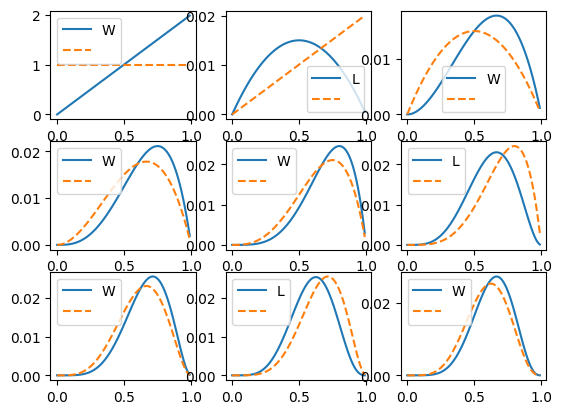

In [78]:
# MCMC for globe tossing example
# continuous space
n_samples = 10000
step_size = 0.1
p = list()
p.append(torch.tensor(0.5))
W = torch.tensor(6.)
L = torch.tensor(3.)
for i in range(1, n_samples):
    # Take a small step away from the previous sample
    p_new = Normal(p[i-1], step_size).sample()
    # If the step is outside [0, 1], squish it back in there
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    # Get the likelihood of the previous/current step
    q0 = Binomial(W+L, p[i-1]).log_prob(W).exp()
    q1 = Binomial(W+L, p_new).log_prob(W).exp()
    # Reject the new sample if the likelihood ratio isn't high enough
    if Uniform(0, 1).sample() < q1/q0:
        p.append(p_new)
    else:
        p.append(p[i-1])

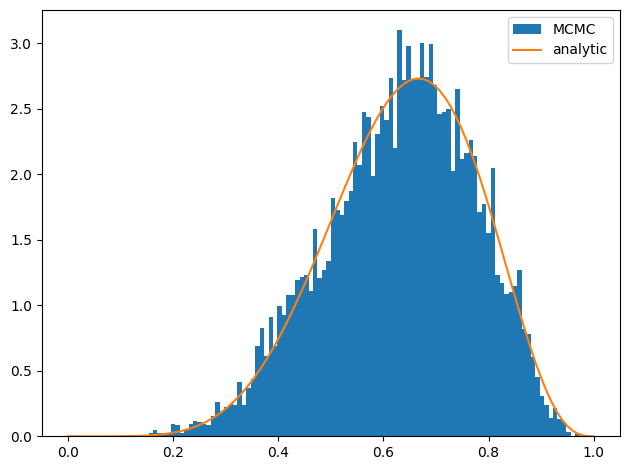

In [79]:
plt.hist(p, bins=100, label="MCMC", density=True)
x = torch.linspace(0, 1, 100)
y = Beta(W+1, L+1).log_prob(x).exp()
plt.plot(x, y, label="analytic")
plt.legend()
plt.show()

### Code 9.4
Illustrate how probability mass in high-dimensional distributions is not necessarily located near the mode. The multidimensional standard normal, for example, has a differential probability mass of
$$
\begin{align}
dp &\propto d^nx\, \exp(-|\vec{x}|^2/2) \\
&\propto dr\, r^{n-1} \exp(-r^2/2)
\end{align}
$$
The radial probability density is proportional to $r^{n-1} \exp(-r^2/2)$, which we can see peaks further away from the mode of the distribution ($r=0$) the greater the dimension $n$.

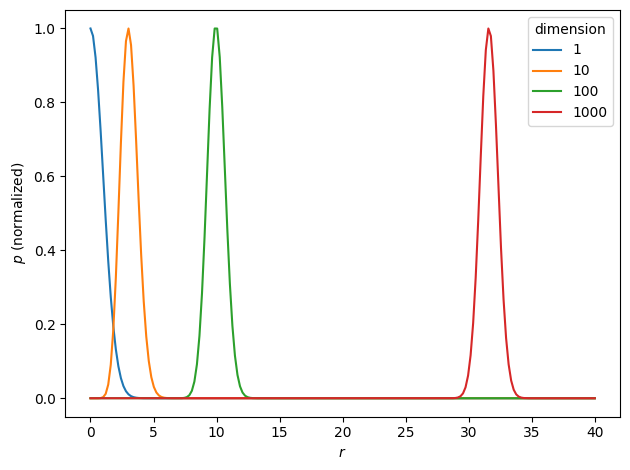

In [80]:
r = np.linspace(1e-3, 40, 200)
for n in (1, 10, 100, 1000):
    # calculate the log of the density first for numerical stability
    logp = (n-1)*np.log(r) - r**2/2
    p = np.exp(logp - logp.max())
    p /= p.max() # normalize to max
    plt.plot(r, p, label=n)
plt.xlabel("$r$")
plt.ylabel("$p$ (normalized)")
plt.legend(title="dimension")
plt.show()

We can sample from a random normal distribution too and show that the distribution of samples matches the theoretical estimate

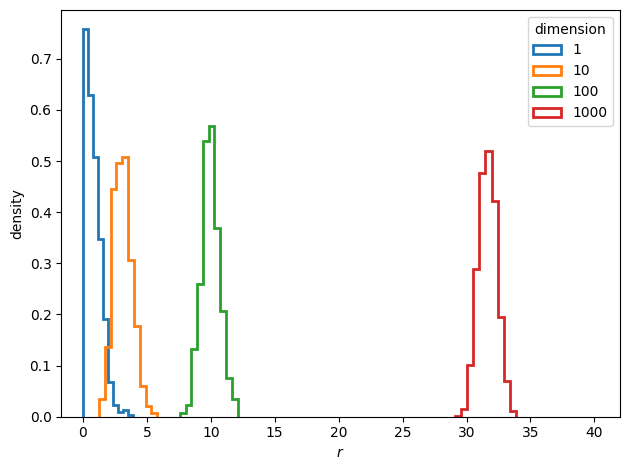

In [81]:
for n in (1, 10, 100, 1000):
    s = np.random.randn(n, 1000) # sample
    s = np.sqrt(np.square(s).sum(axis=0)) # dist from center
    plt.hist(s, density=True, histtype="step", linewidth=2, label=n)

plt.xlim(right=42)
plt.xlabel("$r$")
plt.ylabel("density")
plt.legend(title="dimension", loc="upper right")
plt.show()

### Code 9.5
Let's code up an HMC algorithm for fitting a simple Gaussian. We will need a couple pieces. First off is the "potential energy" function $U$, which is simply the negative log-probability of the model: $U(\theta) = -\ln L(\theta;X)$.

In [82]:
# U needs to return neg-log-probability
def U(q, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    logprob_y = torch.sum(Normal(muy, 1).log_prob(y))
    logprob_x = torch.sum(Normal(mux, 1).log_prob(x))
    logprob_muy = Normal(a, b).log_prob(muy)
    logprob_mux = Normal(k, d).log_prob(mux)
    U = logprob_y + logprob_x + logprob_muy + logprob_mux
    return -U

### Code 9.6

In [141]:
# gradient function
# need vector of partial derivatives of U with respect to vector q
def U_gradient(q, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    G1 = torch.sum(y - muy) + (a - muy) / b**2  # dU/dmuy
    G2 = torch.sum(x - mux) + (k - mux) / b**2  # dU/dmux
    return torch.stack([-G1, -G2])  # negative bc energy is neg-log-prob


# test data    
y = pyro.sample("y", Normal(0,1).expand([50]))
x = pyro.sample("x", Normal(0,1).expand([50]))
x = (x - torch.mean(x)) / torch.std(x)
y = (y - torch.mean(y)) / torch.std(y)

### Code 9.8-9.10

In [142]:
def HMC2(U, grad_U, epsilon, L, current_q):
    """
    This function produces simple sample. Ref. Neal.
    """
    """
    PART 1
    The first chunk of the function chooses random momentum
    — the flick of the particle—and initializes the trajectory.
    """
    q = current_q
    # random flick - p is momentum
    p = Normal(0, 1).sample((q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = torch.full((L + 1, q.shape[0]), torch.nan)
    ptraj = qtraj.clone().detach()
    qtraj[0, :] = current_q[:]
    ptraj[0, :] = p[:]

    """
    PART 2
    Then the action comes in a loop over leapfrog steps. 
    L steps are taken, using the gradient to compute 
    a linear approximation of the log-posterior surface at each point.
    """
    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            # step size: epsilon
            p = p - epsilon * grad_U(q)
            ptraj[i + 1] = p
        qtraj[i + 1] = q

    """
    PART 3
    ensure the proposal is symmetric so the Markov chain is valid 
    and decide whether to accept or reject the proposal.
    """
    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj[L] = p
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential energies and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = torch.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = torch.sum(p**2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = Uniform(tt([0.0]), tt([1.0])).sample()
    """
    The accept/reject decision at the bottom uses the fact that in Hamiltonian dynamics, 
    the total energy of the system must be constant. 
    So if the energy at the start of the trajectory differs substantially from the energy at the end, 
    something has gone wrong. This is known as a divergent transition.
    """
    if runif < torch.exp( (current_U  + current_K) - (proposed_U + proposed_K)):
        new_q = q  # accept
        accept = 1
    else:
        new_q = current_q  # reject
    return {
        "q": new_q,
        "traj": qtraj,
        "ptraj": ptraj,
        "accept": accept,
        "dH": proposed_U + proposed_K - (current_U + current_K),
    }



### Code 9.7

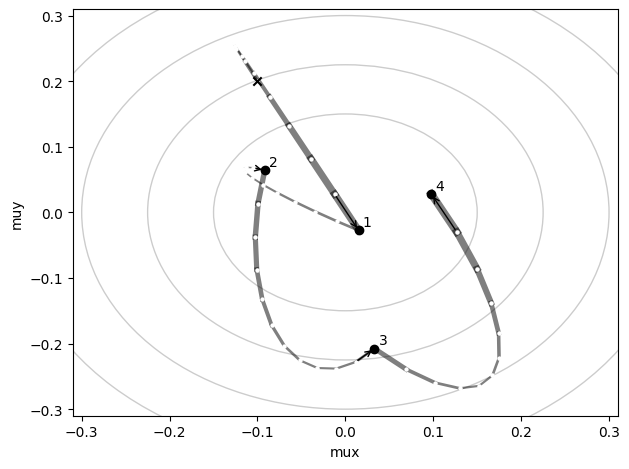

In [143]:
Q = {}
Q["q"] = torch.tensor([-0.1, 0.2])
pr = 0.31
plt.subplot(ylabel="muy", xlabel="mux", xlim=(-pr, pr), ylim=(-pr, pr))
step = 0.03
L = 11  # eps 0.03 / L 28 for U-turns --- 11 for working example
n_samples = 4
path_col = (0, 0, 0, 0.5)
for r in 0.075 * torch.arange(2, 6):
    plt.gca().add_artist(plt.Circle((0, 0), r, alpha=0.2, fill=False))
plt.scatter(Q["q"][0], Q["q"][1], c="k", marker="x", zorder=4)
for i in range(n_samples):
    Q = HMC2(U, U_gradient, step, L, Q["q"])
    if n_samples < 10:
        for j in range(L):
            K0 = torch.sum(Q["ptraj"][j] ** 2) / 2
            plt.plot(
                Q["traj"][j : j + 2, 0],
                Q["traj"][j : j + 2, 1],
                c=path_col,
                lw=1 + 2 * K0,
            )
        plt.scatter(Q["traj"][:, 0], Q["traj"][:, 1], c="white", s=5, zorder=3)
        # for fancy arrows
        dx = Q["traj"][L, 0] - Q["traj"][L - 1, 0]
        dy = Q["traj"][L, 1] - Q["traj"][L - 1, 1]
        d = torch.sqrt(dx**2 + dy**2)
        plt.annotate(
            "",
            (Q["traj"][L - 1, 0], Q["traj"][L - 1, 1]),
            (Q["traj"][L, 0], Q["traj"][L, 1]),
            arrowprops={"arrowstyle": "<-"},
        )
        plt.annotate(
            str(i + 1),
            (Q["traj"][L, 0], Q["traj"][L, 1]),
            xytext=(3, 3),
            textcoords="offset points",
        )
    plt.scatter(
        Q["traj"][L, 0],
        Q["traj"][L, 1],
        c=("red" if torch.abs(Q["dH"]) > 0.1 else "black"),
        zorder=4,
    )

In [86]:
source_HMC2 = inspect.getsourcelines(HMC2)
print("".join("".join(source_HMC2[0]).split("\n\n")[0]))

def HMC2(U, grad_U, epsilon, L, current_q):
    """
    This function produces simple sample. Ref. Neal.
    """
    """
    PART 1
    The first chunk of the function chooses random momentum
    — the flick of the particle—and initializes the trajectory.
    """
    q = current_q
    # random flick - p is momentum
    p = Normal(0, 1).sample((q.shape[0],))
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q) / 2
    # initialize bookkeeping - saves trajectory
    qtraj = torch.full((L + 1, q.shape[0]), torch.nan)
    ptraj = qtraj.clone().detach()
    qtraj[0, :] = current_q[:]
    ptraj[0, :] = p[:]


In [87]:
print("".join("".join(source_HMC2[0]).split("\n\n")[1]))

    """
    PART 2
    Then the action comes in a loop over leapfrog steps. 
    L steps are taken, using the gradient to compute 
    a linear approximation of the log-posterior surface at each point.
    """
    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p  # Full step for the position
        # Make a full step for the momentum, except at end of trajectory
        if i != (L - 1):
            # step size: epsilon
            p = p - epsilon * grad_U(q)
            ptraj[i + 1] = p
        qtraj[i + 1] = q


In [88]:
print("".join("".join(source_HMC2[0]).split("\n\n")[2]))

    """
    PART 3
    ensure the proposal is symmetric so the Markov chain is valid 
    and decide whether to accept or reject the proposal.
    """
    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q) / 2
    ptraj[L] = p
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential energies and kinetic energies at start and end of trajectory
    current_U = U(current_q)
    current_K = torch.sum(current_p**2) / 2
    proposed_U = U(q)
    proposed_K = torch.sum(p**2) / 2
    # Accept or reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    runif = Uniform(tt([0.0]), tt([1.0])).sample()
    """
    The accept/reject decision at the bottom uses the fact that in Hamiltonian dynamics, 
    the total energy of the system must be constant. 
    So if the energy at the start of the trajectory differs substantially from the e

### Code 9.9 - 9.16
Now let's test out some HMC. We will just use `pyro`'s built-in NUTS kernel.

In [89]:
rugged_df = pd.read_csv("data/rugged.csv", sep=";")
rugged_df.head()

isocode  isonum      country  rugged  rugged_popw  rugged_slope  rugged_lsd  \
0     ABW     533        Aruba   0.462        0.380         1.226       0.144   
1     AFG       4  Afghanistan   2.518        1.469         7.414       0.720   
2     AGO      24       Angola   0.858        0.714         2.274       0.228   
3     AIA     660     Anguilla   0.013        0.010         0.026       0.006   
4     ALB       8      Albania   3.427        1.597        10.451       1.006   

   rugged_pc  land_area     lat  ...  africa_region_w  africa_region_e  \
0      0.000       18.0  12.508  ...                0                0   
1     39.004    65209.0  33.833  ...                0                0   
2      4.906   124670.0 -12.299  ...                0                0   
3      0.000        9.0  18.231  ...                0                0   
4     62.133     2740.0  41.143  ...                0                0   

   africa_region_c  slave_exports  dist_slavemkt_atlantic  \
0                0            0.0                     NaN   
1                0            0.0                     NaN   
2                1      3610000.0                   5.669   
3                0            0.0                     NaN   
4                0            0.0                     NaN   

   dist_slavemkt_indian  dist_slavemkt_saharan  dist_slavemkt_redsea  \
0                   NaN                    NaN                   NaN   
1                   NaN                    NaN                   NaN   
2                 6.981                  4.926                 3.872   
3                   NaN                    NaN                   NaN   
4                   NaN                    NaN                   NaN   

    pop_1400  european_descent  
0      614.0               NaN  
1  1870829.0               0.0  
2  1223208.0               2.0  
3        NaN               NaN  
4   200000.0             100.0  

[5 rows x 51 columns]

In [90]:
d = rugged_df.assign(log_gdp=np.log(rugged_df["rgdppc_2000"]))
dd = d[~d["log_gdp"].isna()].copy()
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()
dd["cid"] = dd["cont_africa"].astype(int)

Let's first fit the model using our Gaussian approximation

  0%|          | 0/1000 [00:00<?, ?it/s]

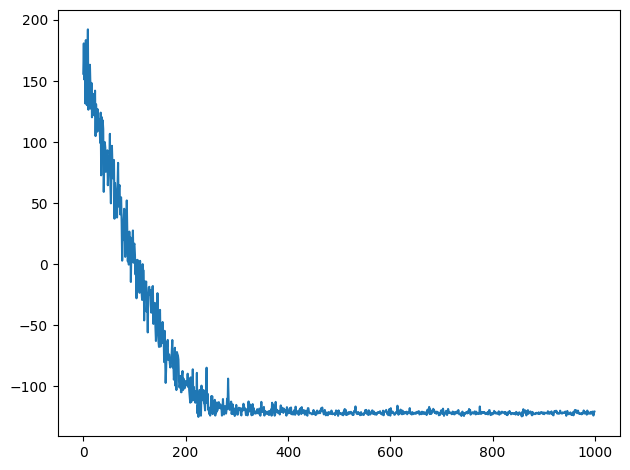

In [91]:
class M8_5(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(1))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(1))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cid
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            with pyro.plate("N"):
                pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cid"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_5 = M8_5(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
loss = m8_5.train(1000)
plt.plot(loss); plt.show()

In [92]:
samples = {"m8.5": sample_posterior(m8_5, 1000, ("a", "b", "sigma"))}
s = samples["m8.5"]
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var].squeeze()[:,i]
    del s[var]
precis(s)

mean    stddev      5.5%     94.5%
sigma  0.111136  0.006108  0.101478  0.121467
a[0]    1.05778  0.010588  1.041887  1.075287
a[1]   0.878935  0.015164  0.853559  0.902603
b[0]  -0.156491  0.057454 -0.249122  -0.06286
b[1]   0.144047  0.073588   0.02414  0.261388

Now we can use NUTS to perform inference:

In [93]:
# Define the model; no guide needed
class M9_1:
    def __init__(self, df, categoricals=None):
        if categoricals is None:
            categoricals = []
        for col in set(df.columns) - set(categoricals):
            setattr(self, col, tt(df[col].values).double())
        for col in categoricals:
            setattr(self, col, tt(df[col].values).long())
    
    def model(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(1))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(1))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cid
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            with pyro.plate("N"):
                pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cid"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
        
    def train(self, num_warmup, num_samples, num_chains=1):
        # apparently multiple chains does not work on windows; I should switch over to 
        # my ubuntu partition and try it out later
        kernel = NUTS(self.model, adapt_step_size=True, adapt_mass_matrix=True, jit_compile=True)
        self.engine = MCMC(kernel, num_samples, num_warmup, num_chains=num_chains)
        self.engine.run()

In [94]:
m9_1 = M9_1(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))
m9_1.train(1000, 1000, 1)

Sample: 100%|██████████| 2000/2000 [00:04, 407.79it/s, step size=7.00e-01, acc. prob=0.912]


In [95]:
# The secret to getting multiple chains to work is
# 1. the model must be a function, not an object. this causes pickling errors otherwise
# 2. do NOT set `torch.multiprocessing.set_start_method`; I found competing advice on
#    this but it seems not to work if this is called
# 3. do NOT use Windows. it can't handle the multiprocessing for some reason. I did this
#    on Ubuntu 18.04. I wonder if this works in WSL...

def format_data(df, categoricals=None):
    data = dict()
    if categoricals is None:
        categoricals = []
    for col in set(df.columns) - set(categoricals):
        data[col] = tt(df[col].values).double()
    for col in categoricals:
        data[col] = tt(df[col].values).long()
    return data

def model_m9_1(data, training=False):
    a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(1))
    b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(1))
    sigma = pyro.sample("sigma", Exponential(1.))
    A = data["cid"]
    mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
    if training:
        with pyro.plate("N"):
            pyro.sample("log_gdp_std", Normal(mu, sigma), obs=data["log_gdp_std"])
    else:
        return pyro.sample("log_gdp_std", Normal(mu, sigma))

def train_nuts(model, data, num_warmup, num_samples, num_chains=1):
    kernel = NUTS(model, adapt_step_size=False, adapt_mass_matrix=True, jit_compile=True)
    engine = MCMC(kernel, num_samples, num_warmup, num_chains=num_chains)
    engine.run(data, training=True)
    return engine

def train_HMC(model, data, num_warmup, num_samples, num_chains=1):
    kernel = HMC(model, step_size=0.3, num_steps=2) 
    engine = MCMC(kernel, num_samples, num_warmup, num_chains=num_chains)
    engine.run(data, training=True)
    return engine

In [96]:
data = format_data(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))

#m9_1 = train_nuts(model_m9_1, data, 1000, 1000, 3) # I should have 4 cpu's, but pyro only recognizes 3...

m9_1 = train_nuts(model_m9_1, data, 1000, 1000, 1) # I should have 4 cpu's, but pyro only recognizes 3...

Sample: 100%|██████████| 2000/2000 [00:04, 481.44it/s, step size=1.00e+00, acc. prob=0.788]


In [97]:
data = format_data(dd[["log_gdp_std", "rugged_std", "cid"]], categoricals=("cid",))

m9_1 = train_nuts(model_m9_1, data, 1000, 1000, 1)
samples["m9.1"] = {k: v.numpy() for k, v in m9_1.get_samples().items()}

Sample: 100%|██████████| 2000/2000 [00:04, 491.10it/s, step size=1.00e+00, acc. prob=0.809]


In [98]:
samples["m9.1"] = {k: v.numpy() for k, v in m9_1.get_samples().items()}
s = samples["m9.1"]
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,i]
    del s[var]
precis(s)

mean    stddev      5.5%     94.5%
sigma  0.111487  0.006267  0.102623  0.122112
a[0]   1.050881  0.009772  1.035248  1.066826
a[1]   0.886644  0.015893  0.861524  0.912724
b[0]  -0.146002  0.053901  -0.23006 -0.060369
b[1]    0.13292  0.077621  0.013038  0.256376

I ran the above with a single chain (i.e. chain of samples), but you can run multiple chains in parallel. It is actually more efficient if you have multiple cores. (I know in tensorflow probability, you can use your GPU to sample, and this lets you do thousands of chains in parallel with no performance hit! Don't think this is available in pytorch unfortunately).

## Code 9.17 - 9.19
Let's analyze the results of this first HMC trial.

The pyro MCMC class tries to copy Stan as much as possible, so there are some convenience utilities that allow you to easily analyze the inference at a glance that are available in both:

In [99]:
m9_1.summary(prob=0.89)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.05      0.01      1.05      1.03      1.07   1653.41      1.00
      a[1]      0.89      0.02      0.89      0.86      0.91   1707.37      1.00
      b[0]     -0.15      0.05     -0.15     -0.23     -0.06   1852.30      1.00
      b[1]      0.13      0.08      0.13      0.02      0.26   1217.08      1.00
     sigma      0.11      0.01      0.11      0.10      0.12   1423.31      1.00

Number of divergences: 0


We can see that even though we drew 1000 _actual_ samples, there are over 1000 _effective_ samples! This is because NUTS is so good, that the sampler can produce sequential samples that are better than uncorrelated (i.e. the autocorrelation between samples is actually negative).

Let's visualize the correlation of the samples

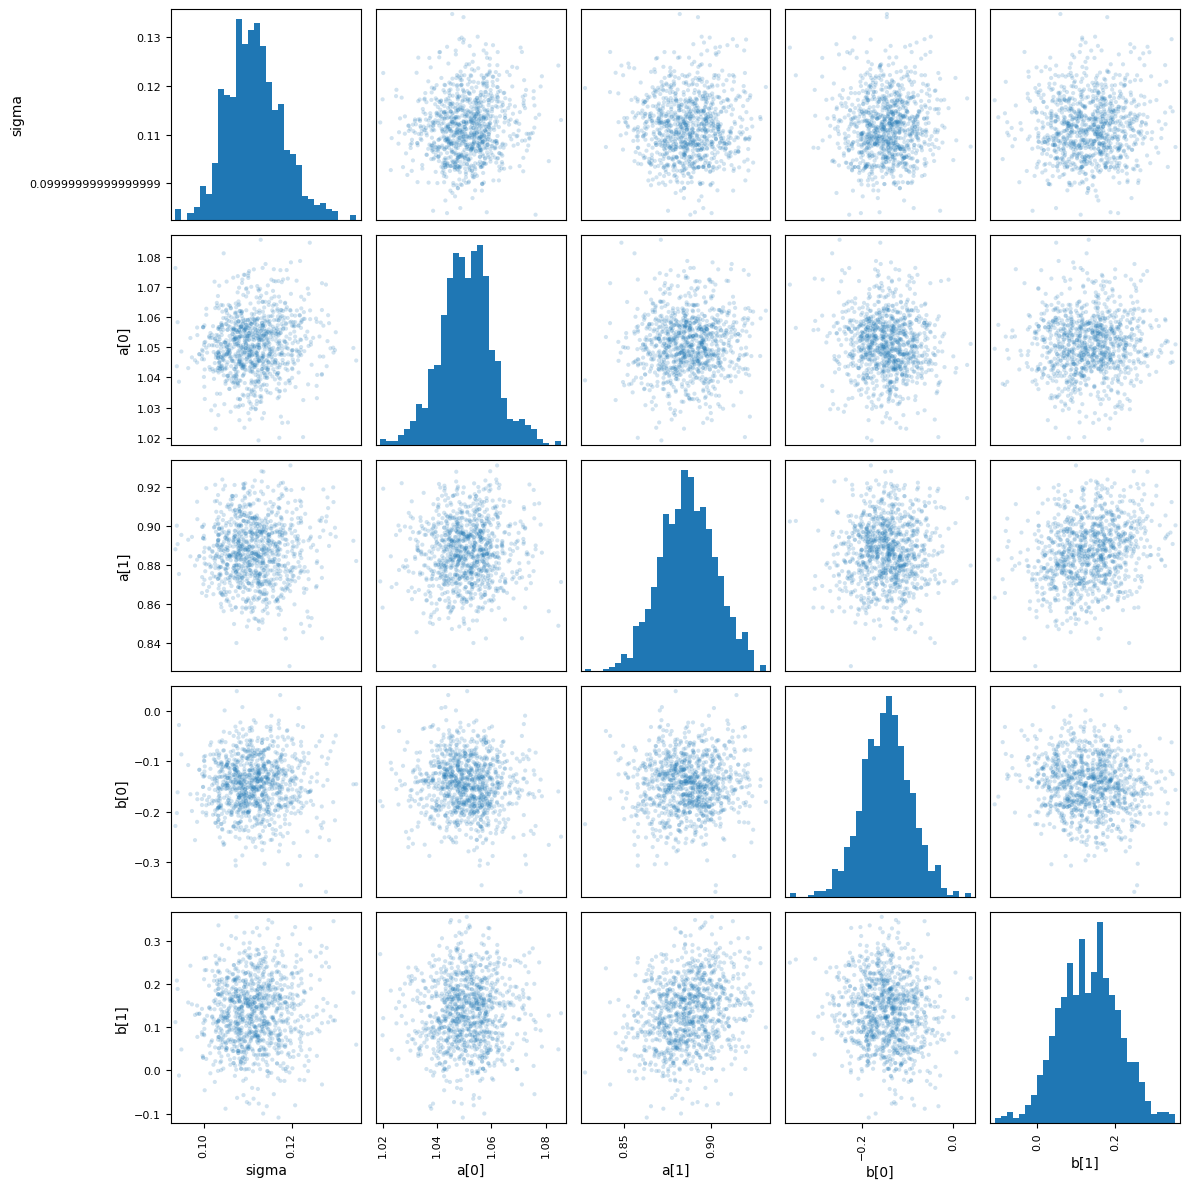

In [100]:
x = pd.DataFrame(s)
pd.plotting.scatter_matrix(x, hist_kwds={"bins": 30}, alpha=0.2, figsize=(12, 12))
plt.show()

Now let's visualize the Markov chain in sequential order. We want to check the chain for stationarity (no trend), mixing (rapid exploration of the full posterior - no slow drifting), and convergence (multiple chains stick around the same area)

In [101]:
def traceplot(s, num_chains):
    fig, axes = plt.subplots(nrows=len(s), figsize=(12, len(s)*num_chains))
    for (k, v), ax in zip(s.items(), axes):
        plt.sca(ax)
        for c in range(num_chains):
            plt.plot(v[c], linewidth=1)
        plt.ylabel(k)
    plt.xlabel("Sample index")
    return fig

dict_keys(['a', 'b', 'sigma'])
5


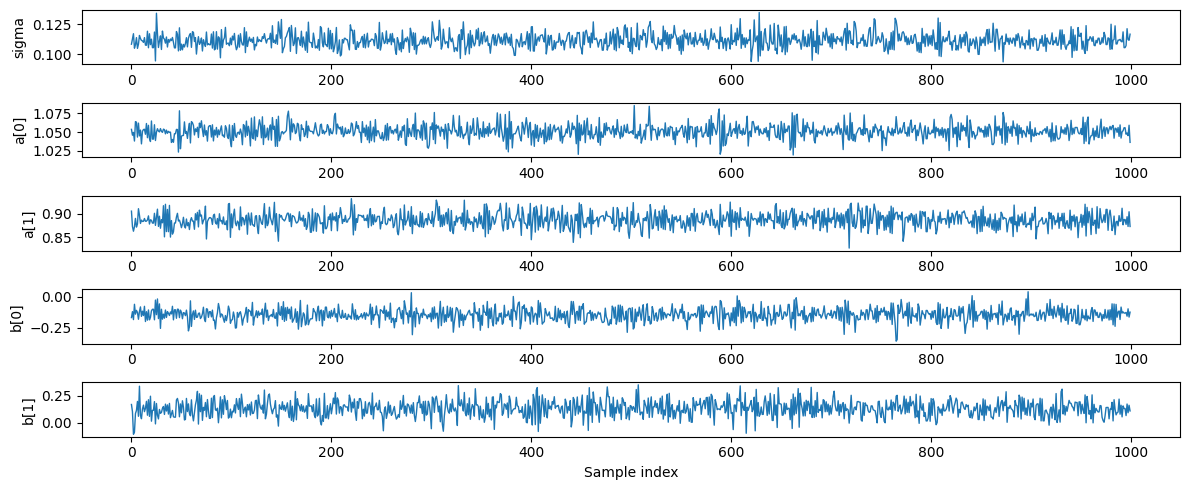

In [102]:
s = {k: v.numpy() for k, v in m9_1.get_samples(group_by_chain=True).items()}
print(s.keys())
for var in ("a", "b"):
    for i in (0, 1):
        s[f"{var}[{i}]"] = s[var][:,:,i]
    del s[var]
print(len(s))
f = traceplot(s, 1)
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


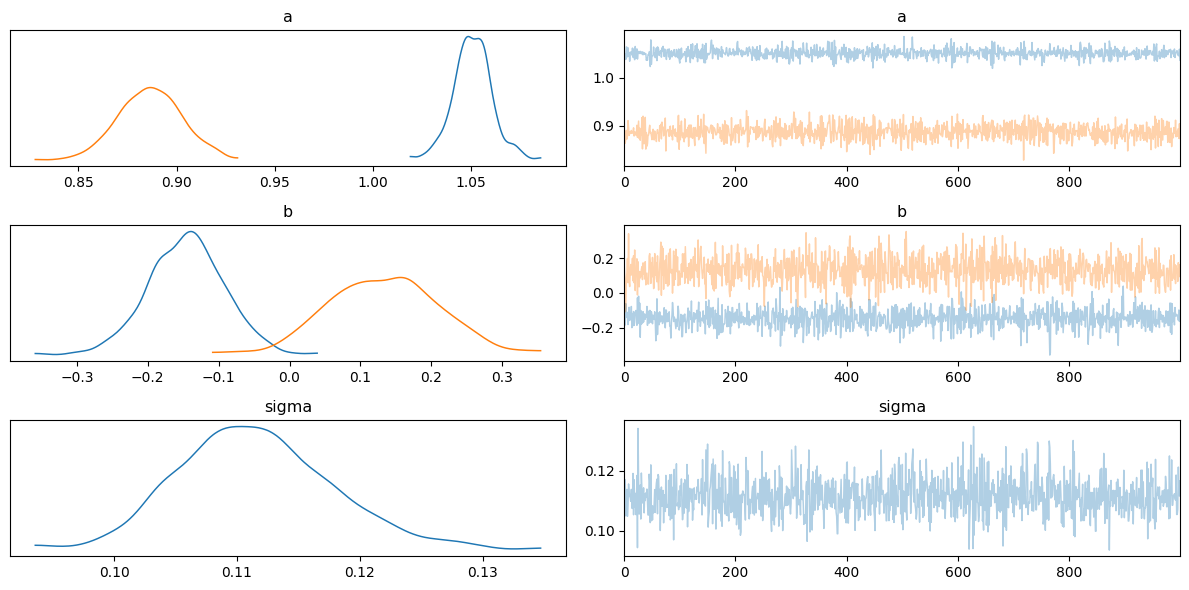

In [103]:
az.plot_trace(az.from_pyro(m9_1))
plt.show()

This looks pretty good, I guess. All the chains seem to converge on the same area of parameter space, and there doesn't seem to be any drifting or non-stationarity.

We will also visualize the convergence with a "trace rank plot" - you take all the samples from a single parameter, rank them from highest to lowest, then create an individual histogram of the ranks within each chain. There should be no correlation.

In [104]:
def trankplot(s, num_chains):
    fig, axes = plt.subplots(nrows=len(s), figsize=(12, len(s)*num_chains))
    ranks = {k: np.argsort(v, axis=None).reshape(v.shape) for k, v in s.items()}
    num_samples = 1
    for p in list(s.values())[0].shape:
        num_samples *= p
    bins = np.linspace(0, num_samples, 30)
    for i, (ax, (k, v)) in enumerate(zip(axes, ranks.items())):
        for c in range(num_chains):
            ax.hist(v[c], bins=bins, histtype="step", linewidth=2, alpha=0.5)
        ax.set_xlim(left=0, right=num_samples)
        # recompute the ax.dataLim
        ax.relim()
        # update ax.viewLim using the new dataLim
        ax.autoscale_view()
        ax.set_yticks([])
        ax.set_ylabel(k)
    plt.xlabel("sample rank")
    return ranks, fig

In [105]:
s.keys()
s["sigma"].shape

(1, 1000)

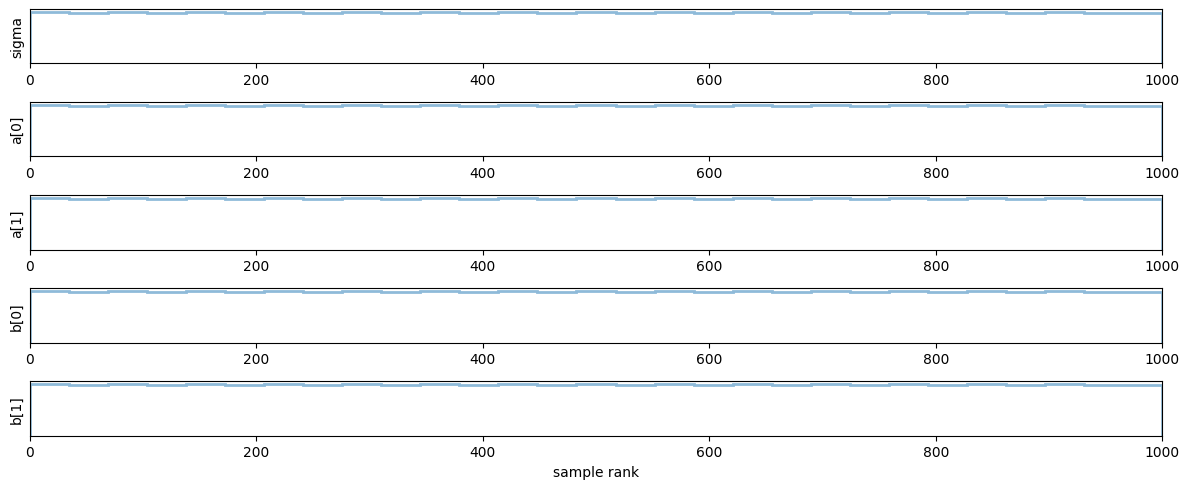

In [106]:
ranks, fig = trankplot(s, 1)
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


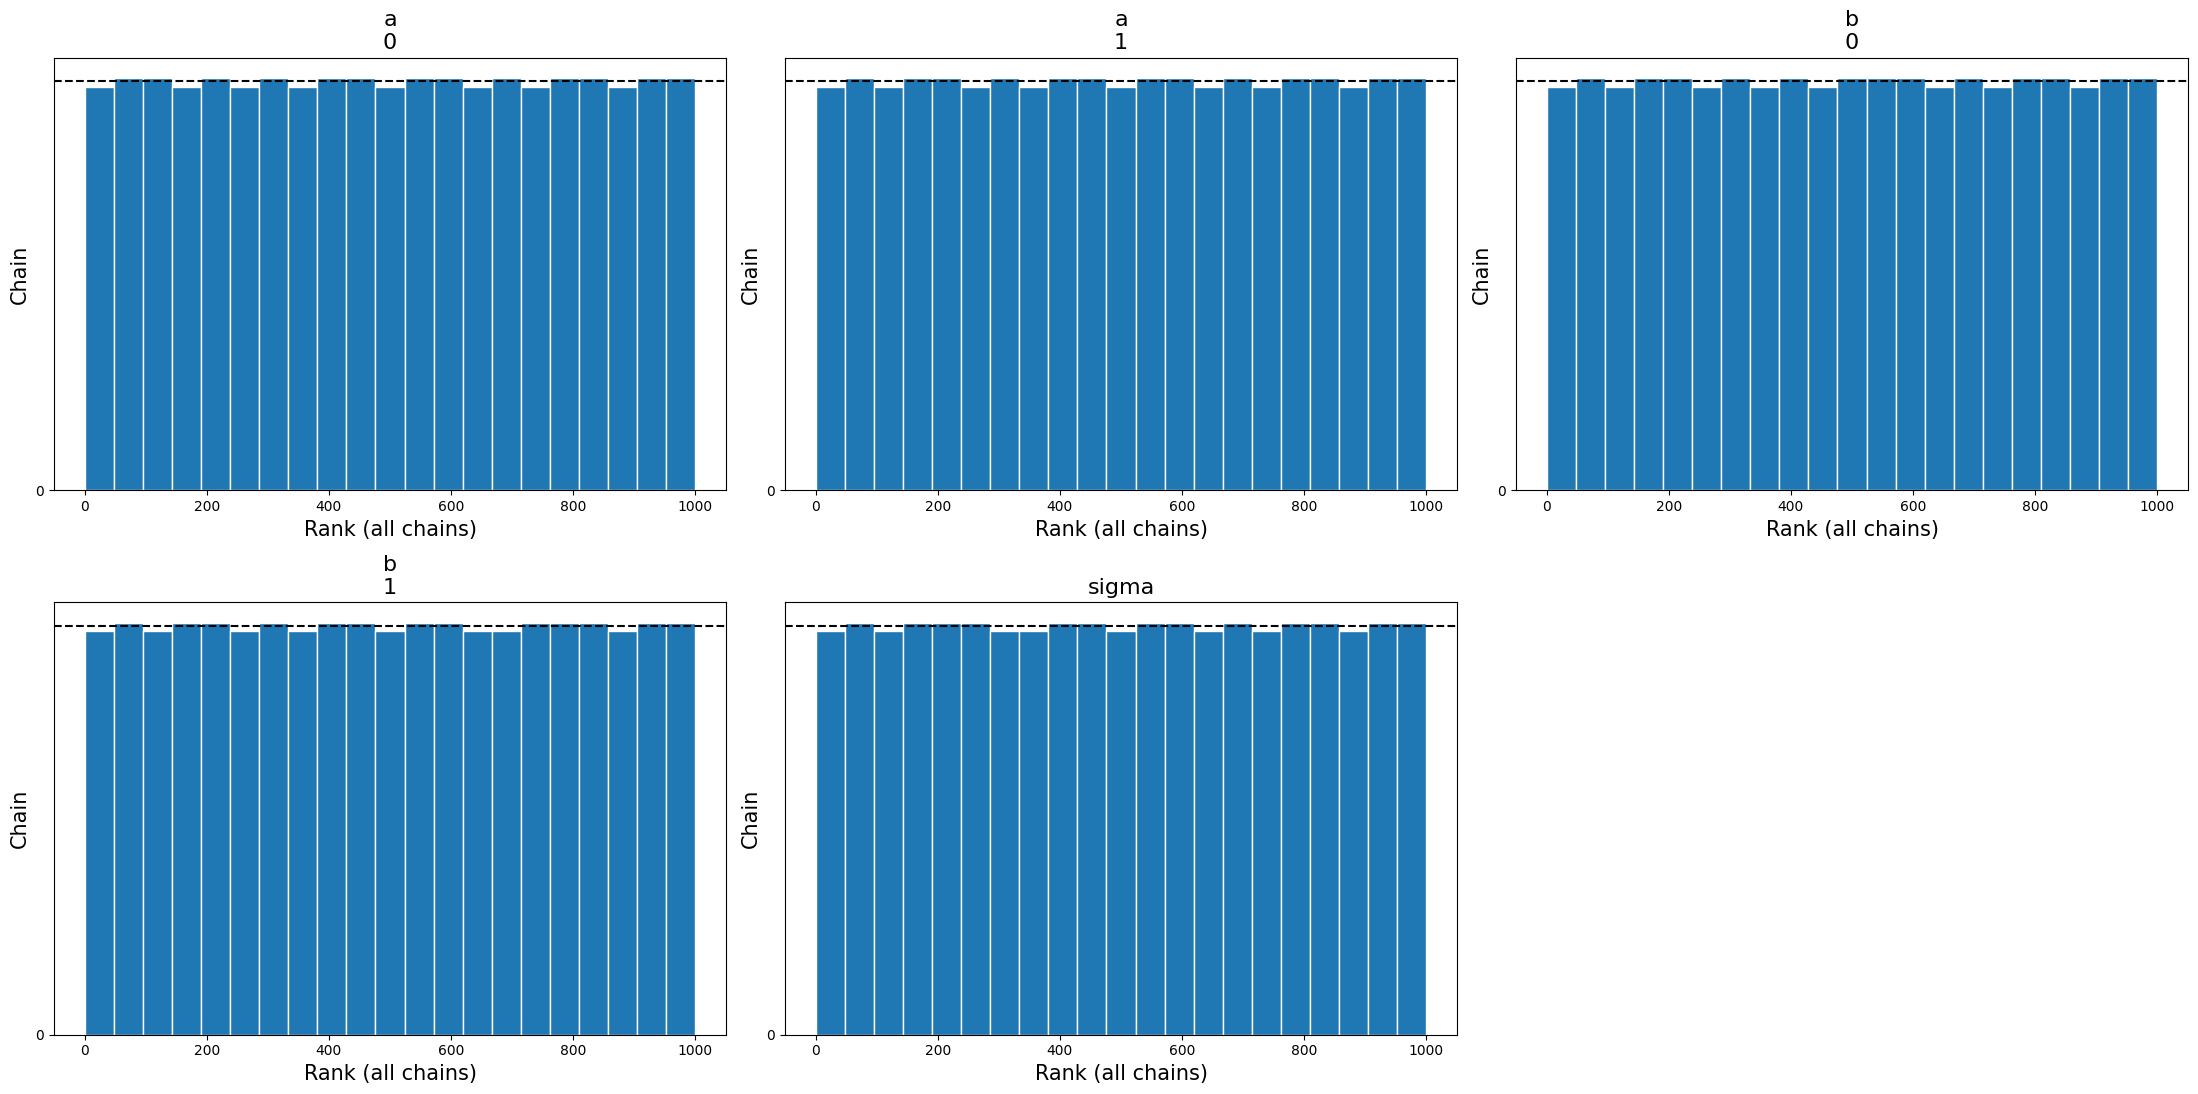

In [107]:
az.plot_rank(az.from_pyro(m9_1))
plt.show()

In [108]:
ranks.keys()
ranks["sigma"].shape


(1, 1000)

### Code 9.20 - 9.22
Now that we know how to build these diagnostic tools, let's see what they look like when things go wrong with our HMC inference.

In [109]:
data = {"y": tt([-1., 1.])}

def model_m9_2(data, training=False):
    a = pyro.sample("a", Normal(0., 1000.))
    sigma = pyro.sample("sigma", Exponential(0.0001))
    mu = a
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
num_chain = 1
m9_2 = train_nuts(model_m9_2, data, 1000, 1000, num_chain)

Sample: 100%|██████████| 2000/2000 [03:53,  8.57it/s, step size=1.00e+00, acc. prob=1.000]  


Ok, seems alright... the acceptance probability looks pretty low though. What about $n_{eff}$ and $\hat{R}$?

In [110]:
m9_2.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -2.47      9.53     -0.03    -17.39     11.60      8.99      1.13
     sigma     40.38    129.77      7.50      0.49     69.70    215.69      1.00

Number of divergences: 0


Wow, something is really wrong. $n_{eff}$ is super small, the std for the parameters is HUGE... I would expect it to be $O(1)$. Let's take a look at our diagnostic plots:

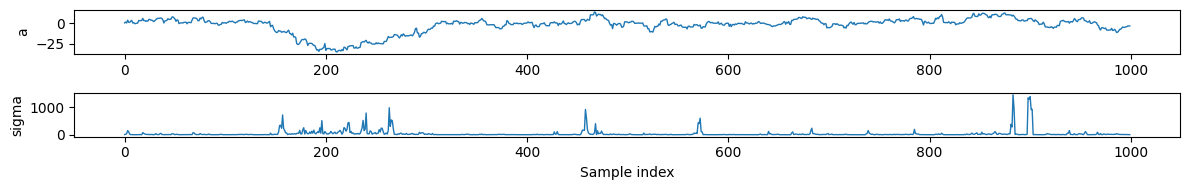

In [111]:
s = {k: v.numpy() for k, v in m9_2.get_samples(group_by_chain=True).items()}
traceplot(s, num_chain)
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


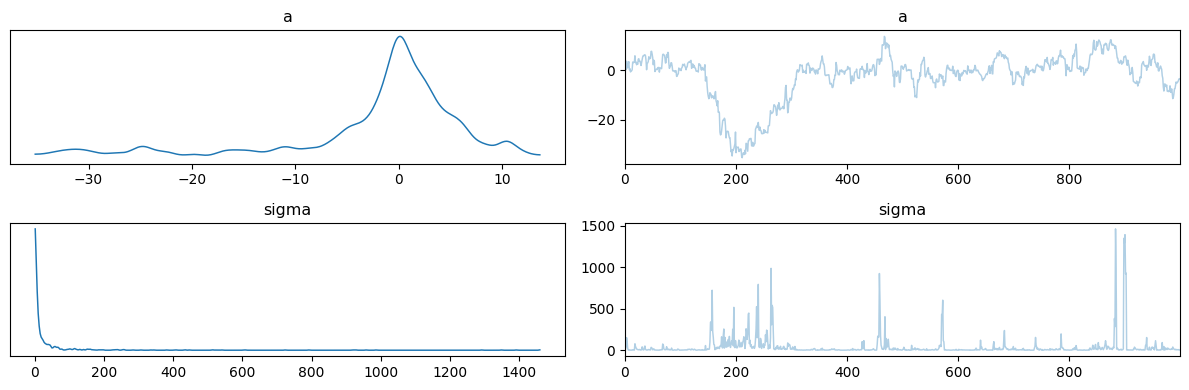

In [112]:
az.plot_trace(az.from_pyro(m9_2))
plt.show()

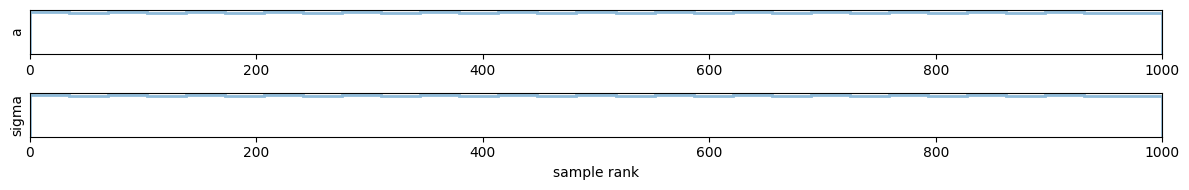

In [113]:
trankplot(s, num_chain)
plt.show()

These look very different from what we got before. In the trace plot, the chains bounce around wildly from point to point, never settling or converging properly. There is a good deal of autocorrelation as well. In the rank plot, the distribution of ranks highly nonuniform. There are massive gaps in the support for either chain.

How do we fix this? Well if we take a look at the priors we specified for `m9_2`, they are clearly ridiculous. Our data, $[-1, 1]$ has a mean of 0 and a standard deviation of O(1). The uncertainty on $a$'s prior is 1000 times larger! And the value of $\sigma$ makes no sense either; why is $a$ so uncertain, but the $\sigma$ is not? Let's specify more sensible priors.

In [114]:
data = {"y": tt([-1., 1.])}

def model_m9_3(data, training=False):
    a = pyro.sample("a", Normal(1., 10.))
    sigma = pyro.sample("sigma", Exponential(1.))
    mu = a
    if training:
        with pyro.plate("N"):
            pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
num_chain = 1
m9_3 = train_nuts(model_m9_3, data, 1000, 1000, num_chain)

Sample: 100%|██████████| 2000/2000 [00:01, 1101.44it/s, step size=1.00e+00, acc. prob=0.627]


In [115]:
m9_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.06      1.12     -0.04     -2.00      1.61    359.07      1.00
     sigma      1.54      0.78      1.33      0.49      2.53    360.09      1.00

Number of divergences: 22


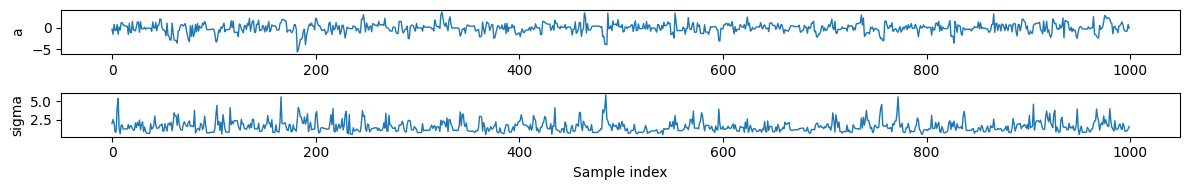

In [116]:
traceplot(m9_3.get_samples(group_by_chain=True), num_chain)
plt.show()

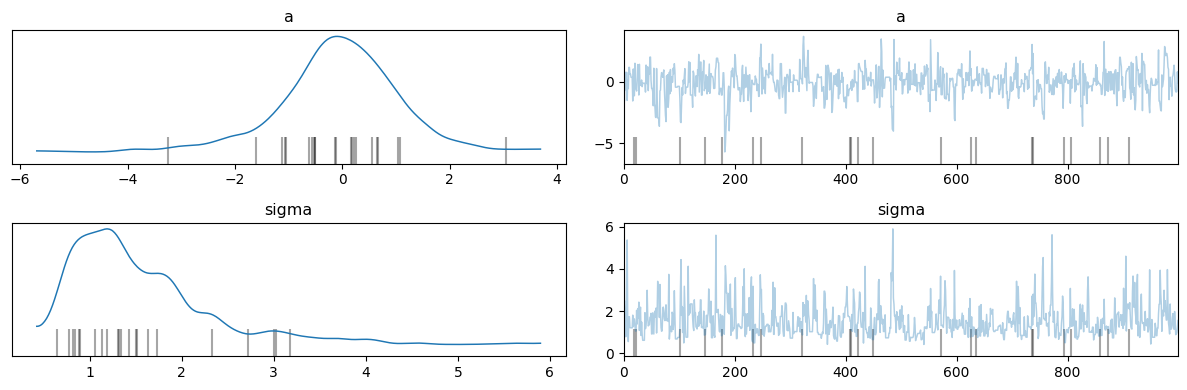

In [117]:
az.plot_trace(az.from_pyro(m9_3))
plt.show()

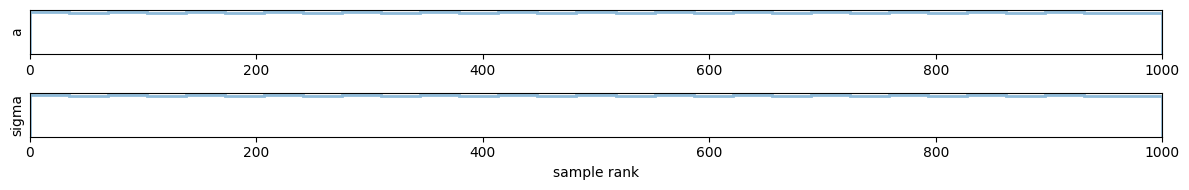

In [118]:
trankplot(m9_3.get_samples(group_by_chain=True), num_chain)
plt.show()

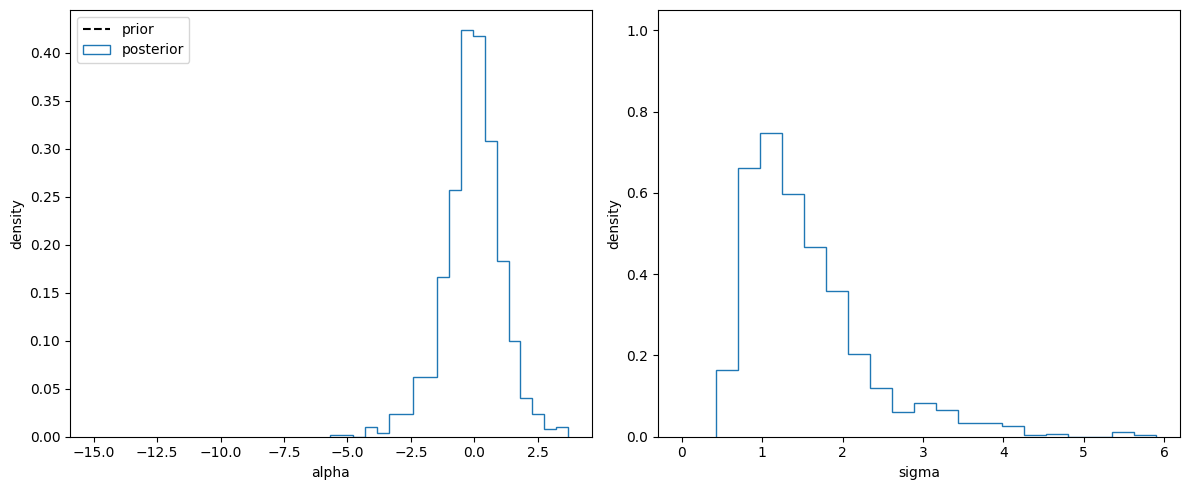

In [119]:
s = {k: v.numpy() for k, v in m9_3.get_samples().items()}
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
# alpha
plt.sca(axes[0])
x = torch.linspace(-15, 15, steps=1)
plt.plot(x, Normal(1., 10.).log_prob(x).exp(), color="black", linestyle="--", label="prior")
plt.hist(s["a"], bins=20, histtype="step", density=True, label="posterior")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("density")
# sigma
plt.sca(axes[1])
x = torch.linspace(0, 10, steps=1)
plt.plot(x, Exponential(1.).log_prob(x).exp(), color="black", linestyle="--", label="prior")
plt.hist(s["sigma"], bins=20, histtype="step", density=True, label="posterior")
plt.xlabel("sigma")
plt.ylabel("density")
plt.show()

### Code 9.23
There can also be problems with HMC when parameters are non-identifiable (though this problem is by no means unique to HMC). For example, if we define a model like
$$
y_i \sim \text{Normal}(\mu, \sigma) \\
\mu = \alpha_1 + \alpha_2 \\
\sigma \sim \text{Exp}(1)
$$
our choice of prior for the $\alpha_i$ will influence the convergence of our model. On a fundamental level, this model is misspecified, because we could reparametrize $\alpha_2 = -\alpha_1 + \mu$ and just sample from $\mu$ directly (i.e. we really only need one parameter, not two).

In [120]:
data = {"y": torch.randn((100,))}

def model_m9_4(data, training=False):
    a1 = pyro.sample("a1", Normal(0., 1000.))
    a2 = pyro.sample("a2", Normal(0., 1000.))
    sigma = pyro.sample("sigma", Exponential(1.))
    mu = a1 + a2
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_4 = train_nuts(model_m9_4, data, 1000, 1000, 1)

Sample: 100%|██████████| 2000/2000 [02:55, 11.41it/s, step size=1.00e+00, acc. prob=1.000]


In [121]:
m9_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a1    -90.58     15.35    -89.60   -115.19    -67.25      2.82      2.31
        a2     90.62     15.35     89.23     67.06    115.26      2.82      2.31
     sigma      0.96      0.07      0.95      0.85      1.06    640.68      1.00

Number of divergences: 0


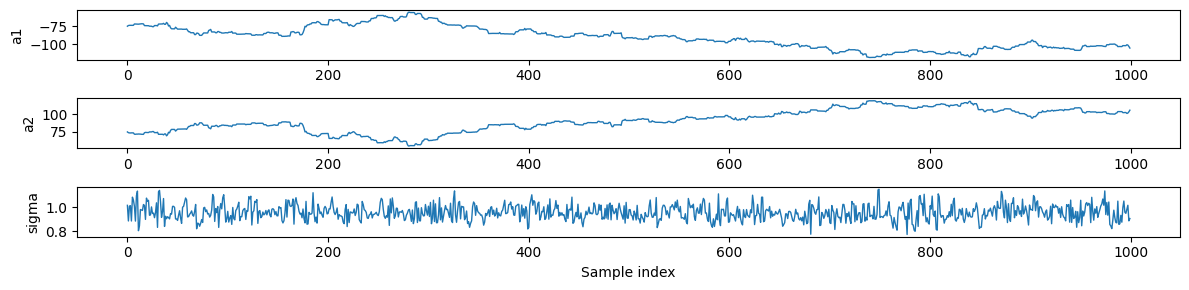

In [122]:
traceplot(m9_4.get_samples(group_by_chain=True), 1)
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


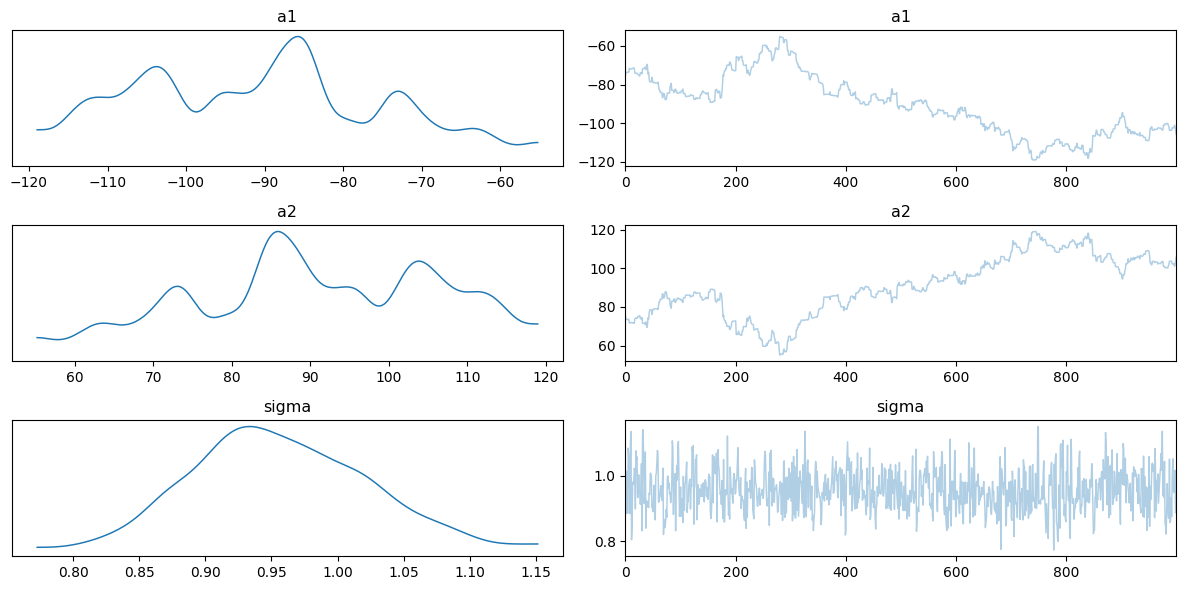

In [123]:
az.plot_trace(az.from_pyro(m9_4))
plt.show()

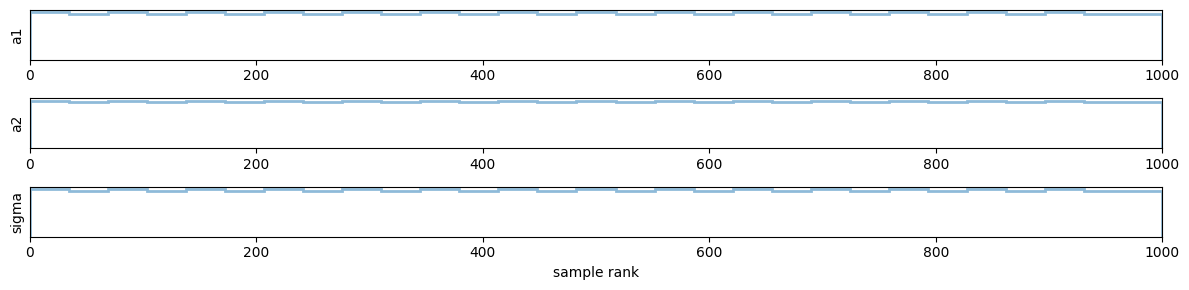

In [124]:
trankplot(m9_4.get_samples(group_by_chain=True), 1)
plt.show()

This looks really bad. Let's try some regularizing priors.

In [125]:
def model_m9_5(data, training=False):
    a1 = pyro.sample("a1", Normal(0., 10.))
    a2 = pyro.sample("a2", Normal(0., 10.))
    sigma = pyro.sample("sigma", Exponential(1.))
    mu = a1 + a2
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_5 = train_nuts(model_m9_5, data, 1000, 1000, 1)

Sample: 100%|██████████| 2000/2000 [02:50, 11.71it/s, step size=1.00e+00, acc. prob=1.000] 


In [126]:
m9_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a1     -3.10      7.15     -2.44    -16.38      7.59      4.65      1.74
        a2      3.15      7.15      2.44     -7.59     16.40      4.65      1.74
     sigma      0.96      0.07      0.96      0.85      1.08    546.01      1.00

Number of divergences: 0


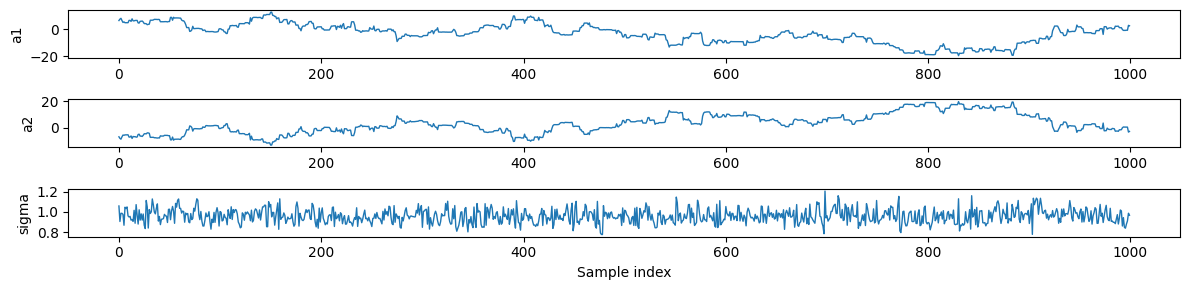

In [127]:
traceplot(m9_5.get_samples(group_by_chain=True), 1)
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


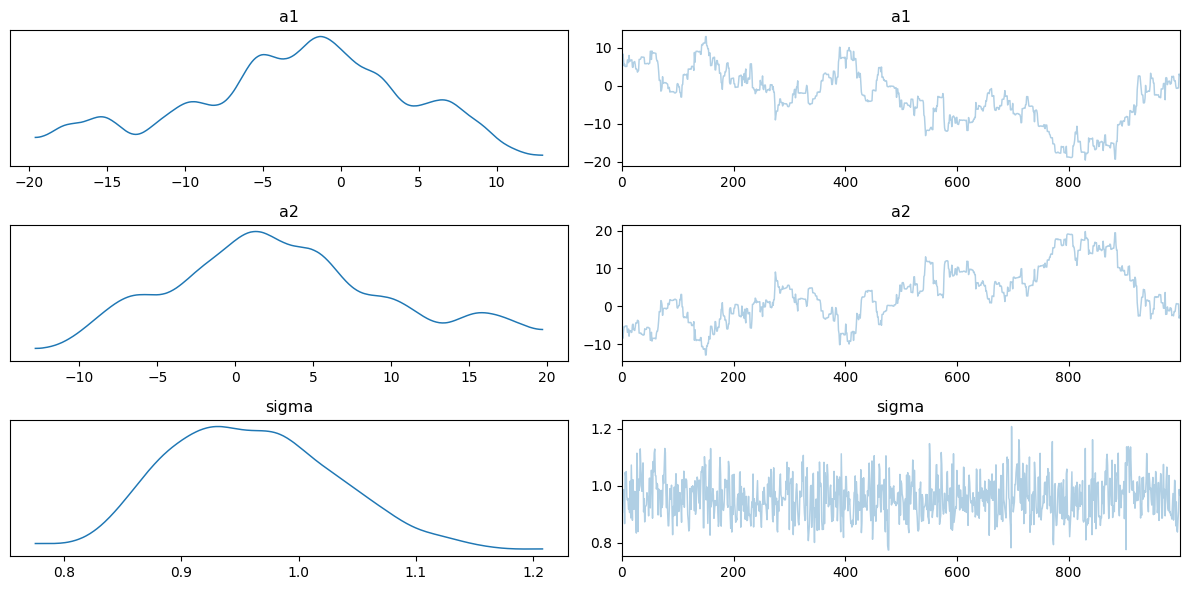

In [128]:
az.plot_trace(az.from_pyro(m9_5))
plt.show()

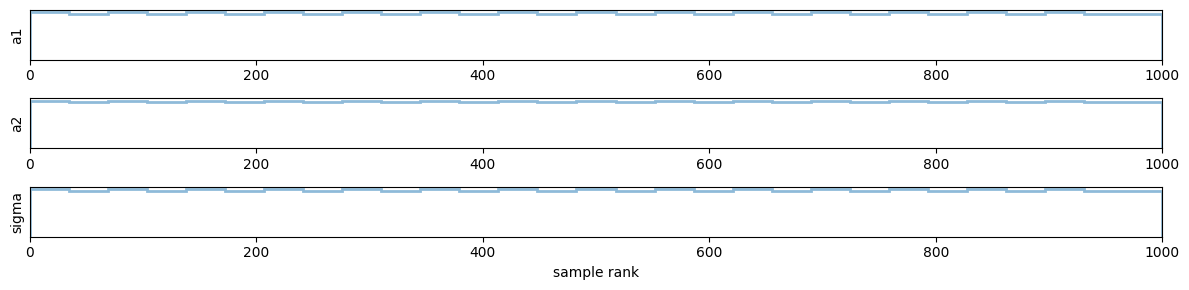

In [129]:
trankplot(m9_5.get_samples(group_by_chain=True), 1)
plt.show()

That looks a little better... but there are still problems with mixing in the `a1/a2` parameters. Let's just eliminate them entirely

In [130]:
def model_m9_6(data, training=False):
    # sqrt(2) = 1.41, and var(a1 + a2) = var(a1) + var(a2) for independent normals
    mu = pyro.sample("mu", Normal(0., 14.1))
    sigma = pyro.sample("sigma", Exponential(1.))
    if training:
        pyro.sample("y", Normal(mu, sigma), obs=data["y"])
    else:
        return pyro.sample("y", Normal(mu, sigma))
    
m9_6 = train_nuts(model_m9_6, data, 1000, 1000, 1)

Sample: 100%|██████████| 2000/2000 [00:02, 947.14it/s, step size=1.00e+00, acc. prob=0.892] 


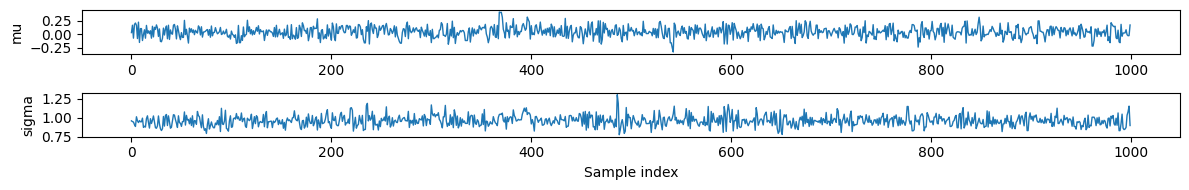

In [131]:
traceplot(m9_6.get_samples(group_by_chain=True), 1)
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


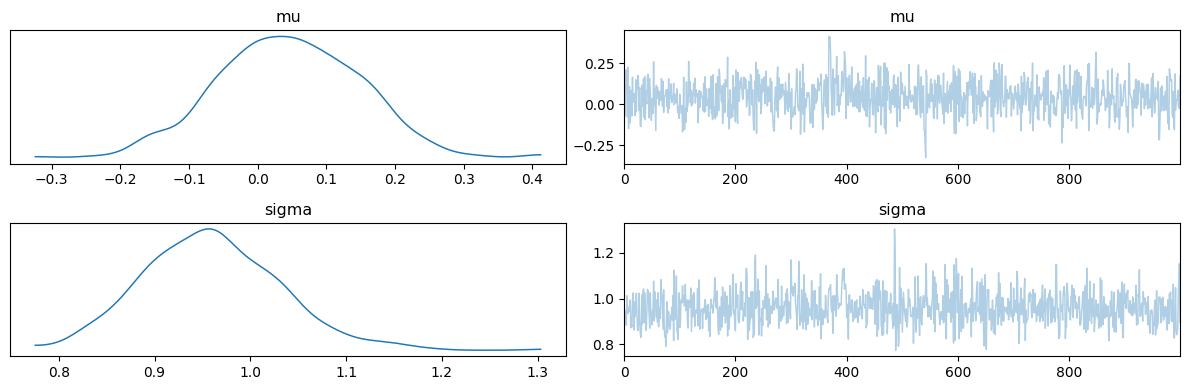

In [132]:
az.plot_trace(az.from_pyro(m9_6))
plt.show()

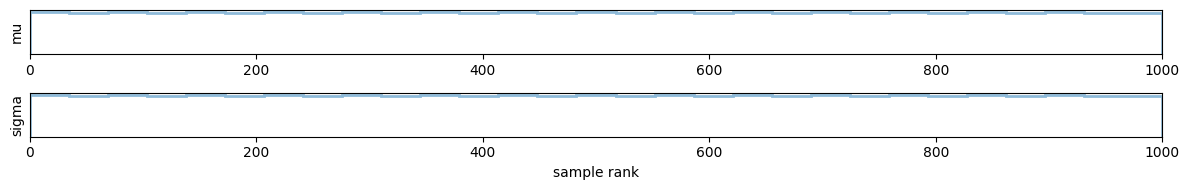

In [133]:
trankplot(m9_6.get_samples(group_by_chain=True), 1)
plt.show()

That ran so much faster, and the chains look a lot healthier!

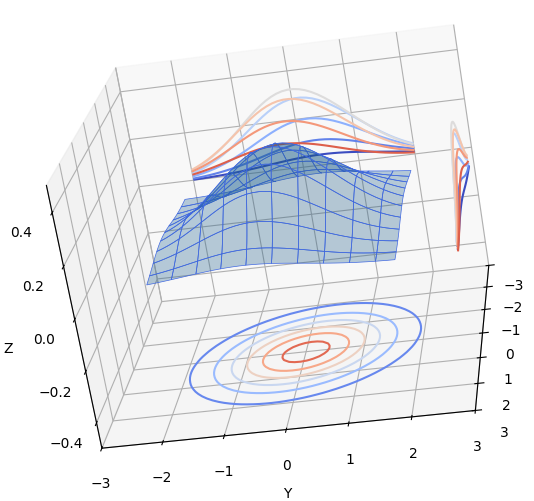

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
# Our 2-dimensional distribution will be over variables X and Y
N = 40
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 1, -0.2], [-0.2,  1]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2)/N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)*2


ax = plt.figure().add_subplot(projection='3d')

# Plot the 3D surface
ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=4, cstride=4,
                alpha=0.3)
ax.view_init(20, 10, 10)
# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph.
ax.contour(X, Y, Z, zdir='z', offset=-0.5, cmap='coolwarm')
ax.contour(X, Y, Z, zdir='x', offset=-3, cmap='coolwarm')
ax.contour(X, Y, Z, zdir='y', offset=3, cmap='coolwarm')

ax.set(xlim=(-3, 3), ylim=(-3, 3), zlim=(-0.5, 0.5),
       xlabel='X', ylabel='Y', zlabel='Z')
ax.set_box_aspect(None, zoom=1.25)
plt.show()